In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
warnings.filterwarnings("ignore")

In [3]:
os.chdir("D:/Personal Projects/Energy Timeseries Project")

In [4]:
# Read in data
energy_data = pd.read_csv('US_government_energy_data.csv')

# Rename the "YYYYMM" column to "Date"
energy_data.rename(columns={'YYYYMM': 'Date'}, inplace=True)

# Convert the "Date" column to datetime format
energy_data['Date'] = pd.to_datetime(energy_data['Date'], format='%Y%m', errors='coerce')

# Set the "Date" column as the index
energy_data.set_index('Date', inplace=True)

# Filter out rows with NaT values in the Date column
energy_data = energy_data[energy_data.index.notnull()]

# Filter the data for "Primary Energy Imports" or "Primary Energy Exports"
filtered_energy_data = energy_data[(energy_data['Description'] == 'Primary Energy Imports') |
                                   (energy_data['Description'] == 'Primary Energy Exports')]

# Separate the data into two different DataFrames for imports and exports
imports_data = filtered_energy_data[filtered_energy_data['Description'] == 'Primary Energy Imports']
exports_data = filtered_energy_data[filtered_energy_data['Description'] == 'Primary Energy Exports']

In [11]:
# Function to check stationarity using the Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# If data is not stationary, apply differencing
imports_data['Differenced_Value'] = imports_data['Value'].diff().dropna()
exports_data['Differenced_Value'] = exports_data['Value'].diff().dropna()

# Re-check stationarity after differencing
print("Stationarity check for differenced Primary Energy Imports:")
check_stationarity(imports_data['Differenced_Value'])

print("Stationarity check for differenced Primary Energy Exports:")
check_stationarity(exports_data['Differenced_Value'])

Stationarity check for differenced Primary Energy Imports:
ADF Statistic: -6.564467
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Stationarity check for differenced Primary Energy Exports:
ADF Statistic: -3.588030
p-value: 0.005994
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [12]:
# Function to evaluate ARIMA model performance using AIC
def evaluate_arima_model_aic(X, arima_order):
    model = ARIMA(X, order=arima_order)
    model_fit = model.fit()
    return model_fit.aic

In [13]:
# Perform grid search over a range of ARIMA parameters using AIC
def grid_search_arima_aic(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    aic = evaluate_arima_model_aic(data, order)
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                    print('ARIMA%s AIC=%.3f' % (order, aic))
                except:
                    continue
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))
    return best_cfg

In [14]:
# Define the p, d, q ranges to search over
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

In [15]:
# Tune ARIMA model for imports data
print("Tuning ARIMA model for Primary Energy Imports")
best_order_imports = grid_search_arima_aic(imports_data['Differenced_Value'].dropna(), p_values, d_values, q_values)
print("Best ARIMA order for imports data:", best_order_imports)

# Tune ARIMA model for exports data
print("Tuning ARIMA model for Primary Energy Exports")
best_order_exports = grid_search_arima_aic(exports_data['Differenced_Value'].dropna(), p_values, d_values, q_values)
print("Best ARIMA order for exports data:", best_order_exports)

Tuning ARIMA model for Primary Energy Imports
ARIMA(0, 0, 0) AIC=-719.584
ARIMA(0, 0, 1) AIC=-890.082
ARIMA(0, 0, 2) AIC=-888.124
ARIMA(0, 1, 0) AIC=-61.423
ARIMA(0, 1, 1) AIC=-710.986
ARIMA(0, 1, 2) AIC=-879.717
ARIMA(1, 0, 0) AIC=-868.641
ARIMA(1, 0, 1) AIC=-888.176
ARIMA(1, 0, 2) AIC=-909.351
ARIMA(1, 1, 0) AIC=-462.332
ARIMA(1, 1, 1) AIC=-859.029
ARIMA(1, 1, 2) AIC=-877.802
ARIMA(2, 0, 0) AIC=-879.876
ARIMA(2, 0, 1) AIC=-898.064
ARIMA(2, 0, 2) AIC=-722.230
ARIMA(2, 1, 0) AIC=-609.201
ARIMA(2, 1, 1) AIC=-869.972
ARIMA(2, 1, 2) AIC=-868.235
Best ARIMA(1, 0, 2) AIC=-909.351
Best ARIMA order for imports data: (1, 0, 2)
Tuning ARIMA model for Primary Energy Exports
ARIMA(0, 0, 0) AIC=-1473.725
ARIMA(0, 0, 1) AIC=-1616.836
ARIMA(0, 0, 2) AIC=-1621.968
ARIMA(0, 1, 0) AIC=-862.705
ARIMA(0, 1, 1) AIC=-1463.923
ARIMA(0, 1, 2) AIC=-1620.550
ARIMA(1, 0, 0) AIC=-1553.648
ARIMA(1, 0, 1) AIC=-1621.012
ARIMA(1, 0, 2) AIC=-1634.553
ARIMA(1, 1, 0) AIC=-1128.924
ARIMA(1, 1, 1) AIC=-1544.081
ARIMA(1, 

In [16]:
# Seasonal components
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, m) where m=12 for monthly data

In [17]:
# Function to fit SARIMA and forecast
def fit_sarima_and_forecast(data, original_data, order, seasonal_order, steps):
    # Fit SARIMA model
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    
    # Forecast
    forecast = model_fit.get_forecast(steps=steps)
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # Integrate the differenced forecast back to the original scale
    last_observed = original_data.iloc[-1]
    forecast_values_original = forecast_values.cumsum() + last_observed
    
    # Generate dates for the forecasted values
    last_date = original_data.index[-1]
    forecast_dates = pd.date_range(start=last_date, periods=steps+1, freq='M')[1:]
    forecast_values_original.index = forecast_dates
    conf_int.index = forecast_dates

    # Plot actual vs forecast
    plt.figure(figsize=(10, 6))
    plt.plot(original_data.index, original_data, label='Original Data')
    plt.plot(forecast_values_original.index, forecast_values_original, label='Forecast', color='red')
    plt.fill_between(conf_int.index, (conf_int.iloc[:, 0].cumsum() + last_observed), 
                     (conf_int.iloc[:, 1].cumsum() + last_observed), color='pink', alpha=0.3)
    plt.title('SARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (quadrillion BTU)')
    plt.ylim([original_data.min() - 0.5, original_data.max() + 0.5])  # Adjust y-axis limits
    plt.legend()
    plt.show()
    
    return model_fit, forecast_values_original

In [18]:
# Number of steps to forecast
forecast_steps = 36

SARIMA Model for Primary Energy Imports


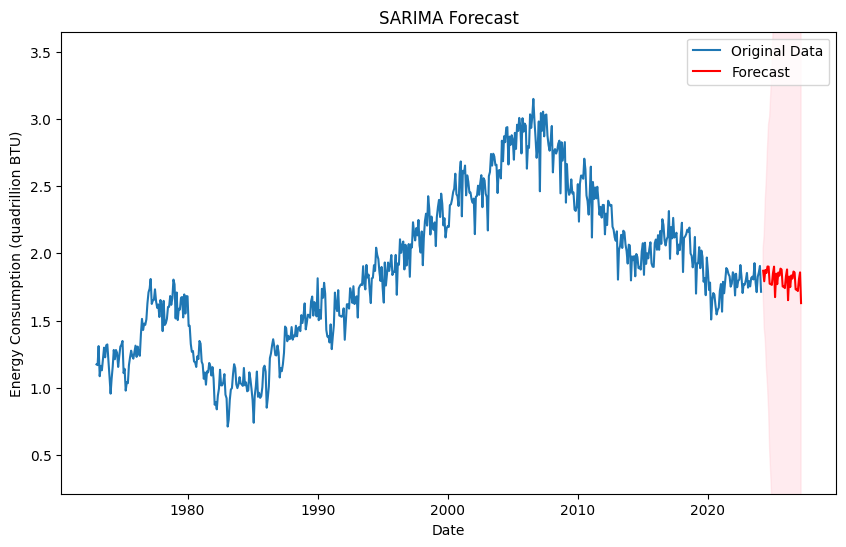

SARIMA Model for Primary Energy Exports


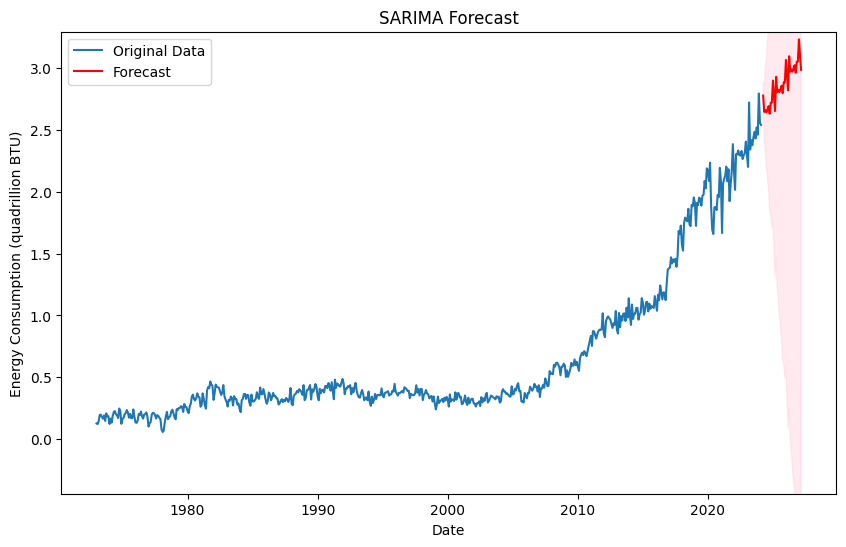

In [19]:
# Fit SARIMA and forecast for imports with the best order
print("SARIMA Model for Primary Energy Imports")
model_imports, forecast_imports = fit_sarima_and_forecast(imports_data['Differenced_Value'].dropna(), imports_data['Value'], best_order_imports, seasonal_order, forecast_steps)

# Fit SARIMA and forecast for exports with the best order
print("SARIMA Model for Primary Energy Exports")
model_exports, forecast_exports = fit_sarima_and_forecast(exports_data['Differenced_Value'].dropna(), exports_data['Value'], best_order_exports, seasonal_order, forecast_steps)

In [20]:
# Check residuals
def check_residuals(model_fit):
    residuals = model_fit.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals)
    plt.title('Residuals Over Time')
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
    
    # Plot the normal distribution curve
    mu, std = stats.norm.fit(residuals)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    plt.title('Histogram of Residuals')
    plt.show()
    
    # Plot the Q-Q plot
    plt.figure(figsize=(10, 6))
    sm.qqplot(residuals, line='s')
    plt.title('Q-Q Plot of Residuals')
    plt.show()
    
    # Plot the ACF of residuals
    plt.figure(figsize=(10, 6))
    sm.graphics.tsa.plot_acf(residuals, lags=40)
    plt.title('ACF of Residuals')
    plt.show()

Residuals check for Primary Energy Imports


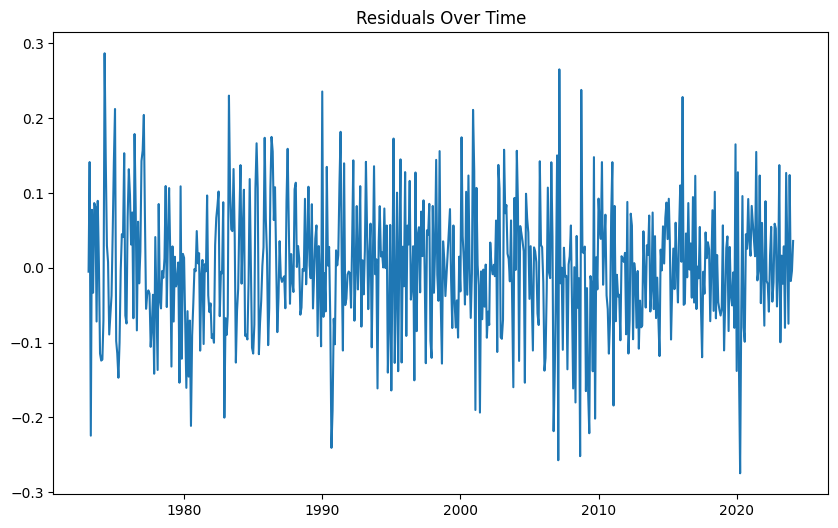

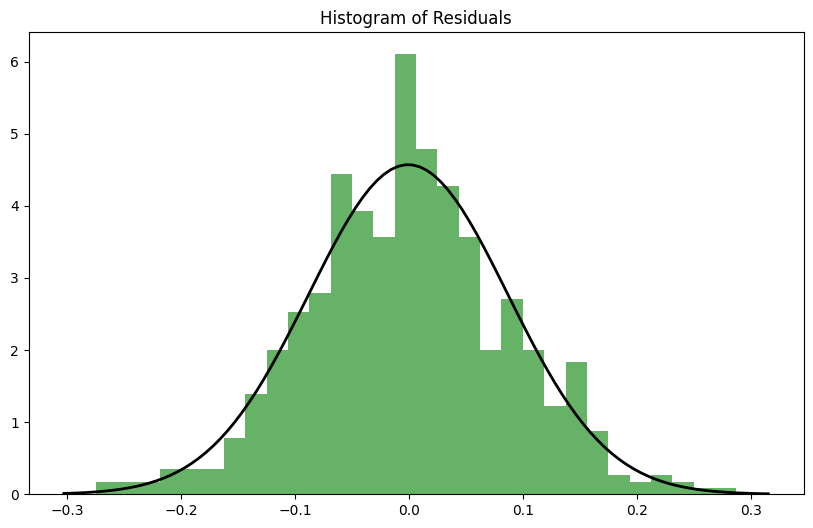

<Figure size 1000x600 with 0 Axes>

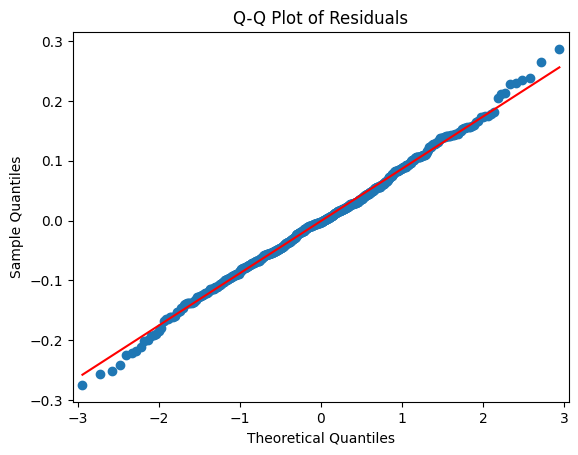

<Figure size 1000x600 with 0 Axes>

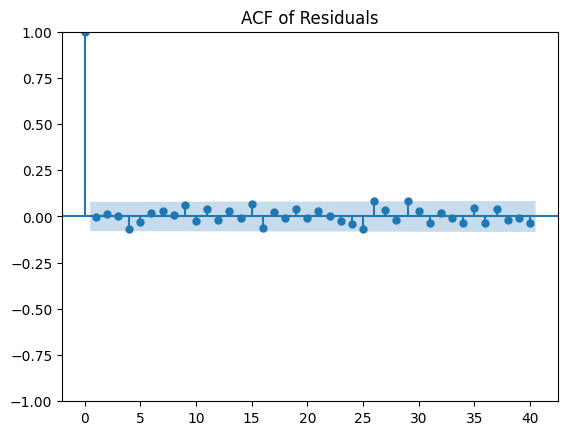

Residuals check for Primary Energy Exports


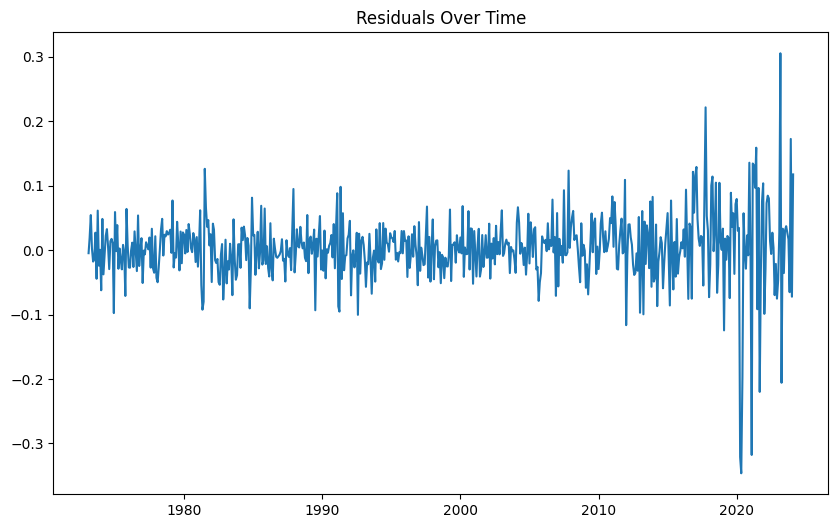

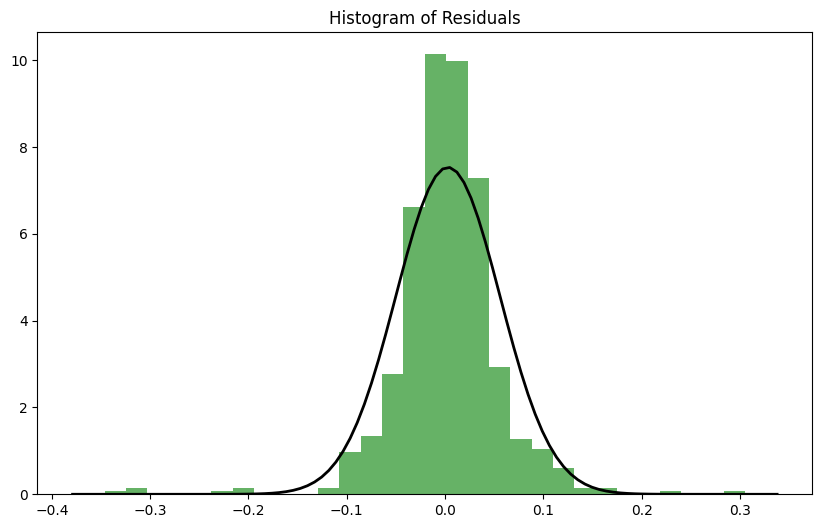

<Figure size 1000x600 with 0 Axes>

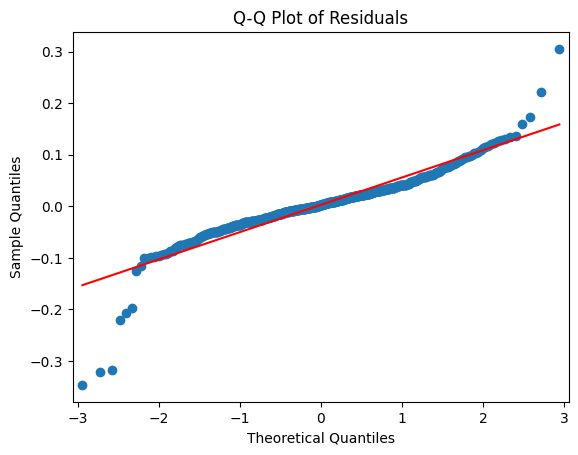

<Figure size 1000x600 with 0 Axes>

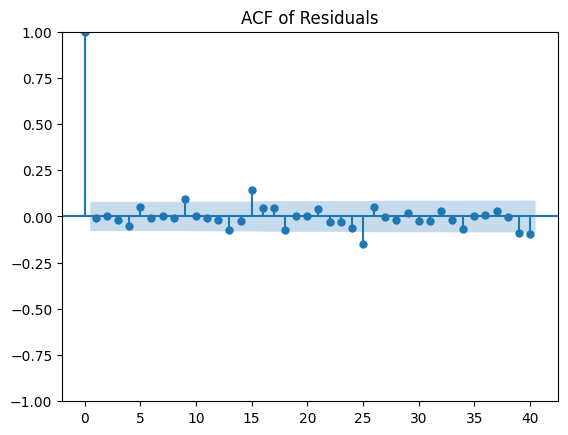

In [21]:
print("Residuals check for Primary Energy Imports")
check_residuals(model_imports)

print("Residuals check for Primary Energy Exports")
check_residuals(model_exports)